In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import itertools
import warnings
import pickle
import joblib
import gzip

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MaxAbsScaler

In [2]:
#Set some global plot defaults
sns.set(rc={"figure.figsize": (10, 8), 'legend.fontsize': 18}) # figsize and leg fontsize of seaborn plots
plt.rc('axes',  labelsize=18)                                  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('axes',  titlesize=18)                                  # fontsize of the title

## Load the data 

In [3]:
with gzip.GzipFile('data/cleaned_df.pkl.gz', 'r') as file:  
    df = joblib.load(file)

## Optimize ARIMA params for the time series data
### Separate each census tract and request category and fit individually. Compare with including census variables (as exog) and not including them.

In [4]:
warnings.filterwarnings("ignore") # specify to ignore warning messages from statsmodels for the ARIMA models

In [5]:
#Function that does the actual hyperparamter tuning
def param_search(params, params_sea, endog_data, exog_data=None):
    
    best_param = best_param_seasonal = ()
    best_aic = best_mse = best_mae = np.inf
    
    model_str = ' '
    if exog_data is not None: model_str = ', with exog vars, '
    print '\tFinding the best fit%sfrom %i parameter combos... ' % (model_str, len(params_sea)*len(params)),
    
    start = time.time()
    for pdq in params:
        for pdq_sea in seasonal_pdq:
            try:    
                mod = sm.tsa.statespace.SARIMAX(endog=endog_data,
                                                exog=exog_data,
                                                order=pdq,
                                                seasonal_order=pdq_sea,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit(disp=False)

                mae = mean_absolute_error(results.fittedvalues, endog_data)
                mse = mean_squared_error (results.fittedvalues, endog_data)

                if best_mae > mae:
                    best_mae = mae
                    best_param = pdq
                    best_param_seasonal = pdq_sea
                    
            except:
                continue
                
    #Print out the time it took        
    end = time.time()
    delta = end - start
    print(' and it took %02d:%02d:%02d.' % (delta//3600., delta//60., delta%60.))      
    print('\t  * Best fitted model is ARIMA{}x{} with score: {:.3f}'.format(best_param, best_param_seasonal, best_mae))
 
    return([best_param, best_param_seasonal, best_mae])

#Function to get the score/forecast of the model
def score_model(model, endog_data, exog_data=None,  
                start_date=pd.to_datetime('2017-10-08'), end_date=pd.to_datetime('2017-12-31')):
    
    try:
        pred = model.get_prediction(start=start_date, end=end_date, exog=exog_data, dynamic=True)
        ci = pred.conf_int()
    except:
        return (-1,0,0)
    
    aic = model.aic
    mae = mean_absolute_error(pred.predicted_mean, endog_data) 
    mse = mean_squared_error(pred.predicted_mean, endog_data) 
        
    return(mae, pred.predicted_mean, ci)

## Define the ARIMA parameters to traverse

In [6]:
d = range(0, 2)
p = q = range(0, 3)#3
pdq = list(itertools.product(p, d, q))
#seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q)) if x[0] + x[1] + x[2] != 0 ]
seasonal_pdq = [(1,0,0,52), (0,1,0,52), (0,0,1,52), (1,1,0,52), (0,1,1,52)]

## Prepare dataframe for modeling.
### Scale the census features to 0-1 so they are all on equal footing.

In [7]:
#Re-scale some features
ts_test = df.copy()
ts_test.drop(['Supervisor_District', 'Police_District', 'Latitude', 'Longitude', 'Source', 'Has_Media_Link', 
                  'Is_Closed'], axis=1, inplace=True)

#Scale to percent
ts_test['Poverty'] = ts_test['Poverty']/100.
ts_test['Unemployment'] = ts_test['Unemployment']/100.
ts_test['Percent_Male'] = ts_test['Percent_Male']/100.

#Scale to 0-1
ts_test['Population'] = MaxAbsScaler().fit_transform(ts_test['Population'].values.reshape(-1,1)).reshape(1,-1)[0]
ts_test['Income'] = MaxAbsScaler().fit_transform(ts_test['Income'].values.reshape(-1,1)).reshape(1,-1)[0]

## Time series model for request category/census tract with and without census variables (exog vars)
### Resampled per week
#### Only go over one tract for each category here, due to computation time. Better results at bottom. 

Street and Sidewalk Cleaning
->  Tract : 106.0
	Finding the best fit, with exog vars, from 90 parameter combos...   and it took 00:10:53.
	  * Best fitted model is ARIMA(1, 0, 1)x(1, 0, 0, 52) with score: 5.178
	Finding the best fit from 90 parameter combos...   and it took 00:03:22.
	  * Best fitted model is ARIMA(2, 1, 2)x(1, 0, 0, 52) with score: 5.398

	Plotting the observed, fit and forecast time series: 


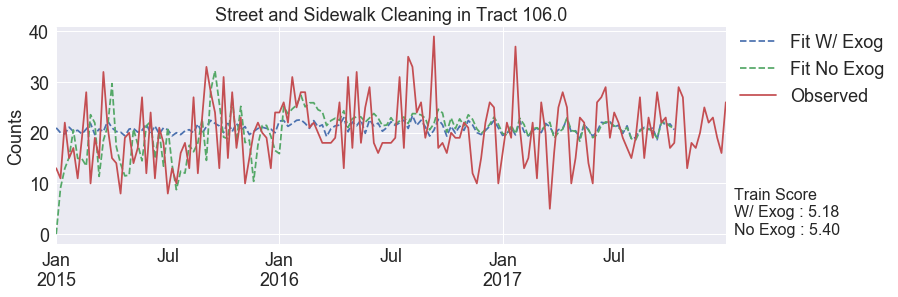

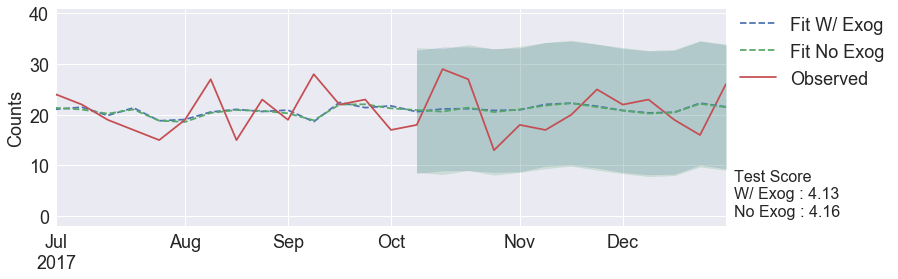

Graffiti
->  Tract : 166.0
	Finding the best fit, with exog vars, from 90 parameter combos...   and it took 00:12:45.
	  * Best fitted model is ARIMA(0, 0, 2)x(1, 0, 0, 52) with score: 10.025
	Finding the best fit from 90 parameter combos...   and it took 00:03:33.
	  * Best fitted model is ARIMA(2, 0, 2)x(1, 0, 0, 52) with score: 11.447

	Plotting the observed, fit and forecast time series: 


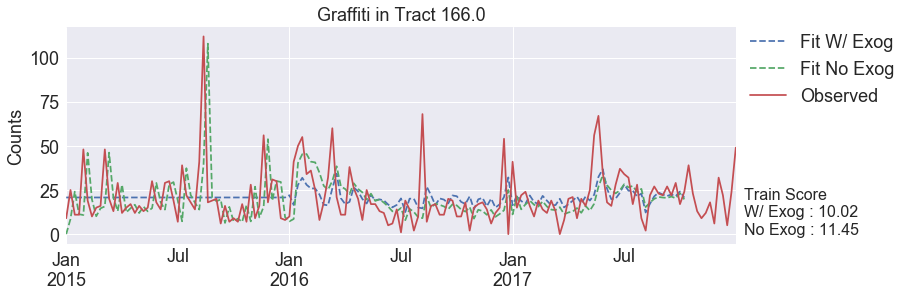

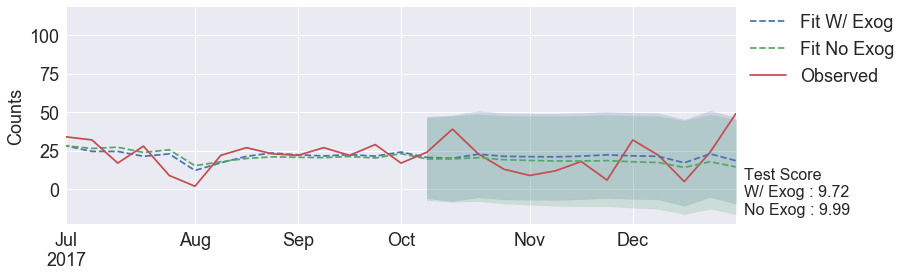

Abandoned Vehicle
->  Tract : 252.0
	Finding the best fit, with exog vars, from 90 parameter combos...   and it took 00:08:21.
	  * Best fitted model is ARIMA(1, 0, 0)x(1, 0, 0, 52) with score: 4.682
	Finding the best fit from 90 parameter combos...   and it took 00:02:31.
	  * Best fitted model is ARIMA(1, 1, 2)x(1, 0, 0, 52) with score: 4.876

	Plotting the observed, fit and forecast time series: 


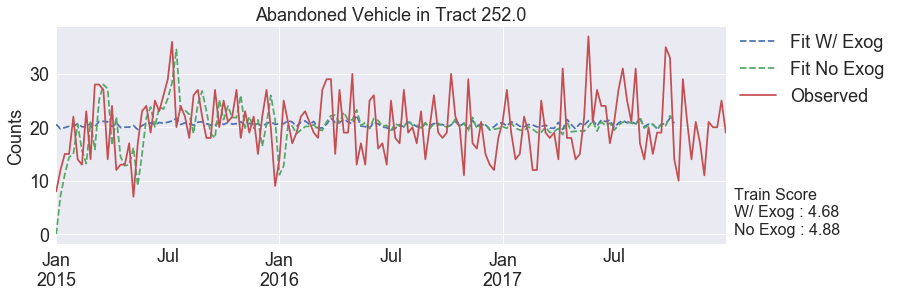

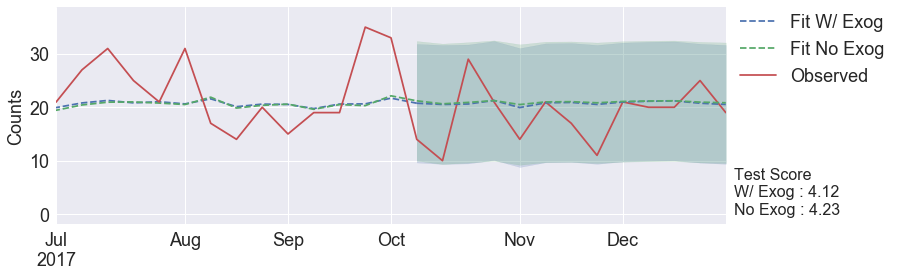

Homeless Concerns
->  Tract : 176.01
	Finding the best fit, with exog vars, from 90 parameter combos...   and it took 00:10:28.
	  * Best fitted model is ARIMA(2, 1, 0)x(1, 0, 0, 52) with score: 6.739
	Finding the best fit from 90 parameter combos...   and it took 00:02:45.
	  * Best fitted model is ARIMA(2, 1, 0)x(1, 0, 0, 52) with score: 6.739

	Plotting the observed, fit and forecast time series: 


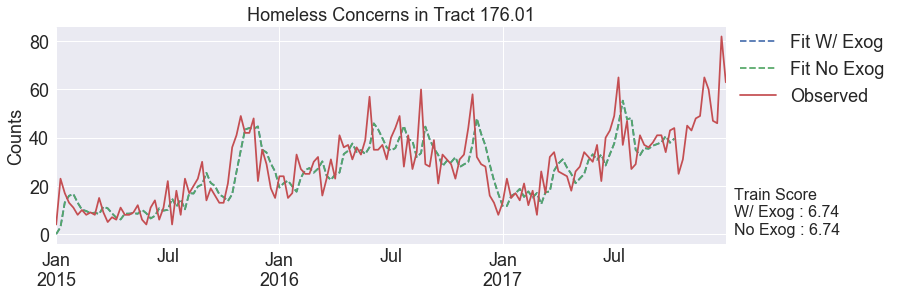

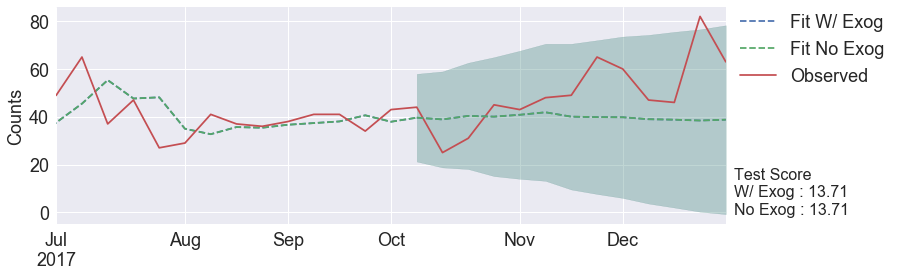

Encampments
->  Tract : 177.0
	Finding the best fit, with exog vars, from 90 parameter combos...   and it took 00:15:50.
	  * Best fitted model is ARIMA(2, 1, 1)x(1, 0, 0, 52) with score: 7.779
	Finding the best fit from 90 parameter combos...   and it took 00:05:39.
	  * Best fitted model is ARIMA(2, 1, 1)x(1, 0, 0, 52) with score: 7.779

	Plotting the observed, fit and forecast time series: 


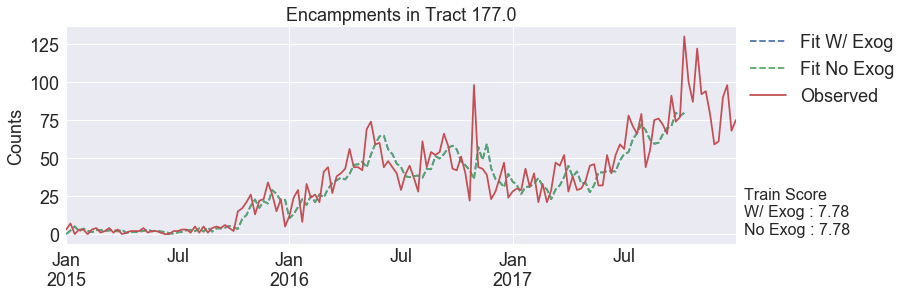

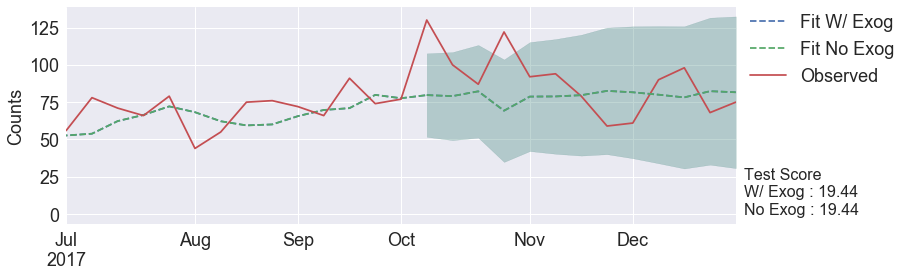

Sewer Issues
Streetlights
Damaged Property


In [8]:
model_i = 0
model_results = pd.DataFrame(columns=['Category', 'Tract', 'Score_exog', 'Score_no_exog'])

for feature in df.Category.value_counts().index:

    time_series = ts_test[ts_test.Category == feature].copy()
    time_series.drop('Category', axis=1, inplace=True)
    print('%s\n%s' % (feature, '='*30))
    
    for tract, group in time_series.groupby('Tract'):
        temp = group.set_index('Opened')['Tract'].resample('W').count().to_frame(name='Counts')

        #Keep only resampled time series with no missing weeks
        if len(temp)==157:
            for col in group.drop(['Opened'], axis=1).columns:
                temp[col] = [group[col].mean()]*len(temp)
        else:
            continue
            
        #Select only those with certain total request counts    
        if len(group) < 3100:
            continue
        
        print('->  Tract : %s' % tract)
        
        x_data = temp.drop(['Counts', 'Tract'], axis=1)
        y_data = temp.drop('Tract', axis=1)['Counts']
        x_train = x_data[:-12]
        y_train = y_data[:-12]
        x_test  = x_data[-12:]
        y_test  = y_data[-13:]
        
        #Tune for best parameters
        best_param, best_param_seasonal, best_score_exog = param_search(pdq, seasonal_pdq, y_train, x_train)
        
        #Forecast with exog (exog=census variables)
        mod_exog = sm.tsa.statespace.SARIMAX(endog=y_train, exog=x_train, 
                                             order=best_param, seasonal_order=best_param_seasonal, 
                                             enforce_invertibility=False, enforce_stationarity=False)
        res_exog = mod_exog.fit(disp=False)
        score_exog, pred_exog, ci_exog = score_model(res_exog, y_test, x_test)
        
        #Forecast without exog
        best_param, best_param_seasonal, best_score_no_exog = param_search(pdq, seasonal_pdq, y_train)
        mod_no_exog = sm.tsa.statespace.SARIMAX(endog=y_train, order=best_param, seasonal_order=best_param_seasonal, 
                                                enforce_invertibility=False, enforce_stationarity=False)
        res_no_exog = mod_no_exog.fit(disp=False)
        score_no_exog, pred_no_exog, ci_no_exog = score_model(res_no_exog, y_test)
            
            
        #Save the results
        model_results.loc['%i' % model_i] = [feature, tract, score_exog, score_no_exog]
        model_i = model_i + 1   
            
        print('\n\tPlotting the observed, fit and forecast time series: ')
            
        #Plot the observed and two fit models    
        plt.figure(figsize=(12,4))    
        res_exog.fittedvalues.plot(label='Fit W/ Exog', linestyle='--')
        res_no_exog.fittedvalues.plot(label='Fit No Exog', linestyle='--')
        temp.Counts.plot(label='Observed')
        plt.title('%s in Tract %s' % (feature, tract))
        plt.ylabel('Counts')
        ax1 = plt.axes()
        ax1.xaxis.label.set_visible(False)
        plt.text(0.91, 0.16, 'Train Score\n%-7s : %.2f\n%-7s : %.2f' % 
                 ('W/ Exog', best_score_exog, 'No Exog', best_score_no_exog), fontsize=16, 
                 transform=plt.gcf().transFigure)
        plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
        plt.show() 
        
        #Plot the observed, fit and forecasted models, in limited date range
        plt.figure(figsize=(12,4))    
        ax = res_exog.fittedvalues.plot(label='Fit W/ Exog', linestyle='--')
        res_no_exog.fittedvalues.plot(label='Fit No Exog', linestyle='--')
        temp.Counts.plot(ax=ax, label='Observed')
        pred_exog.plot(ax=ax, label='_nolegend_', color=sns.color_palette()[0], linestyle='--')
        pred_no_exog.plot(ax=ax, label='_nolegend_', color=sns.color_palette()[1], linestyle='--')

        ax.fill_between(ci_exog.index, ci_exog.iloc[:, 0], ci_exog.iloc[:, 1], 
                        color=sns.color_palette()[0], alpha=0.2)
        ax.fill_between(ci_no_exog.index, ci_no_exog.iloc[:, 0], ci_no_exog.iloc[:, 1], 
                        color=sns.color_palette()[1], alpha=0.2)  
        ax.set_ylabel('Counts')
        plt.text(0.91, 0.16, 'Test Score\n%-7s : %.2f\n%-7s : %.2f' % 
                 ('W/ Exog', score_exog, 'No Exog', score_no_exog), fontsize=16, transform=plt.gcf().transFigure)
        plt.xlim(('2017-07-01','2017-12-31'))
        ax1 = plt.axes()
        ax1.xaxis.label.set_visible(False)
        plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
        plt.show()   
            
        #Only go over one tract per category    
        break

## Including census variables sometimes makes the model better, sometimes worse

In [9]:
model_results['Census_better'] = model_results.Score_exog.round(3) < model_results.Score_no_exog.round(3)
model_results

,Category,Tract,Score_exog,Score_no_exog,Census_better
0,Street and Sidewalk Cleaning,106.00,4.130882,4.163286,True
1,Graffiti,166.00,9.724132,9.993415,True
2,Abandoned Vehicle,252.00,4.124256,4.225361,True
3,Homeless Concerns,176.01,13.710648,13.710648,False
4,Encampments,177.00,19.442141,19.442141,False


## Load in previous results that we saved

In [10]:
out = pd.read_csv('df_res_all_full.csv')
out.drop('Unnamed: 0', axis=1, inplace=True)

### Which categories can be predicted better with census variables?

In [11]:
pd.crosstab(out.Category, out.Census_better, margins=True)

Census_better,False,True,All
Category,,,
Abandoned Vehicle,26,18,44
Damaged Property,4,4,8
Encampments,6,3,9
Graffiti,39,15,54
Homeless Concerns,15,8,23
Sewer Issues,17,12,29
Street and Sidewalk Cleaning,79,54,133
Streetlights,3,7,10
All,189,121,310
